<a href="https://colab.research.google.com/github/agungzrohy/CapstoneProject_IBMGranite_AgungRohy/blob/main/Capstone_Project_IBMGranite_AgungRohy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install replicate kaggle pandas scikit-learn tqdm -q

# Mengimpor library yang akan digunakan
import os
import pandas as pd
import replicate
from google.colab import files
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

print("✅ Library yang dibutuhkan telah terinstal dan diimpor.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.7 MB/s eta 0:00:00
✅ Library yang dibutuhkan telah terinstal dan diimpor.


-----

#### **Konfigurasi API (Kaggle & Replicate)**



In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("\n✅ Konfigurasi Kaggle API berhasil.")

# --- Konfigurasi Replicate API ---
REPLICATE_API_TOKEN = "r8_Vev7HC3xtVUtwl3tL1IqIYicAUexdn031JwDl"
os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN
# Memverifikasi koneksi ke Replicate
try:
    replicate.models.get("ibm-granite/granite-3.3-8b-instruct")
    print("✅ Koneksi ke Replicate API dengan model IBM Granite berhasil.")
except Exception as e:
    print(f"❌ Gagal terhubung ke Replicate. Pastikan API Token Anda benar. Error: {e}")


✅ Konfigurasi Kaggle API berhasil.
✅ Koneksi ke Replicate API dengan model IBM Granite berhasil.


-----

#### **Memuat dan Membersihkan Data**


In [ ]:
# Mengunduh dataset dari Kaggle menggunakan API
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

# Mengekstrak file zip yang telah diunduh
!unzip -o fake-and-real-news-dataset.zip

# Memuat data dari file CSV ke dalam DataFrame pandas
df_true = pd.read_csv('True.csv')
df_fake = pd.read_csv('Fake.csv')

# Menambahkan kolom 'label' untuk membedakan data
df_true['label'] = 'REAL'
df_fake['label'] = 'FAKE'

# Menggabungkan kedua DataFrame menjadi satu
df = pd.concat([df_true, df_fake], ignore_index=True)

# Membuat kolom 'full_text' dengan menggabungkan judul dan isi berita
df['full_text'] = df['title'] + ". " + df['text']

# Memilih kolom yang relevan dan menghapus sisanya
df_final = df[['full_text', 'label']].copy()

# Mengacak urutan data untuk memastikan tidak ada bias urutan
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✅ Dataset berhasil dimuat dan dibersihkan. Total data: {len(df_final)} baris.")
df_final.head()

Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
License(s): CC-BY-NC-SA-4.0
  0% 0.00/41.0M [00:00<?, ?B/s]
100% 41.0M/41.0M [00:00<00:00, 1.15GB/s]
Archive:  fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                
✅ Dataset berhasil dimuat dan dibersihkan. Total data: 44898 baris.


,full_text,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,FAKE
1,Failed GOP Candidates Remembered In Hilarious...,FAKE
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,FAKE
3,California AG pledges to defend birth control ...,REAL
4,AZ RANCHERS Living On US-Mexico Border Destroy...,FAKE


-----

#### **Definisi Fungsi AI (Klasifikasi & Peringkasan)**

In [ ]:
MODEL_IDENTIFIER = "ibm-granite/granite-3.3-8b-instruct"

def create_classification_prompt(article_text):
    """Membuat prompt yang jelas untuk tugas klasifikasi."""
    return f"""
**Instruction:**
Classify the following news article as "REAL" or "FAKE".
Analyze its content, tone, and language.
Provide ONLY one word as the output: "REAL" or "FAKE".

**News Article:**
"{article_text}"

**Classification:**
"""

def create_summary_prompt(article_text):
    """Membuat prompt untuk tugas peringkasan."""
    return f"""
**Instruction:**
Summarize the key points of the following news article in 2-3 sentences.
The summary must be neutral and informative.

**News Article:**
"{article_text}"

**Summary:**
"""

def classify_article(article_text):
    """Mengirim artikel ke IBM Granite dan mendapatkan hasil klasifikasi."""
    prompt = create_classification_prompt(article_text[:4000])
    try:
        output = replicate.run(
            MODEL_IDENTIFIER,
            input={"prompt": prompt, "max_new_tokens": 10}
        )
        result = "".join(output).strip().upper()
        if "REAL" in result:
            return "REAL"
        elif "FAKE" in result:
            return "FAKE"
        else:
            return "UNKNOWN"
    except Exception as e:
        return "ERROR"

def summarize_article(article_text):
    """Mengirim artikel ke IBM Granite untuk diringkas."""
    prompt = create_summary_prompt(article_text[:4000])
    try:
        output = replicate.run(
            MODEL_IDENTIFIER,
            input={"prompt": prompt, "max_new_tokens": 150}
        )
        return "".join(output).strip()
    except Exception:
        return "Gagal membuat ringkasan."

print("✅ Fungsi untuk klasifikasi dan peringkasan telah didefinisikan.")

✅ Fungsi untuk klasifikasi dan peringkasan telah didefinisikan.


-----

####  **Eksekusi Analisis pada Sampel Data**


In [ ]:

# Mengambil sampel data untuk dianalisis.
SAMPLE_SIZE = 100
df_sample = df_final.head(SAMPLE_SIZE).copy()

print(f"Memulai proses klasifikasi pada {len(df_sample)} artikel berita...")

# Menggunakan tqdm untuk menampilkan progress bar
tqdm.pandas(desc="Menganalisis Artikel")
df_sample['predicted_label'] = df_sample['full_text'].progress_apply(classify_article)

print("\n✅ Proses klasifikasi pada sampel data selesai.")
df_sample.head(10)

Memulai proses klasifikasi pada 100 artikel berita...


Menganalisis Artikel: 100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


✅ Proses klasifikasi pada sampel data selesai.


,full_text,label,predicted_label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,FAKE,REAL
1,Failed GOP Candidates Remembered In Hilarious...,FAKE,REAL
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,FAKE,REAL
3,California AG pledges to defend birth control ...,REAL,REAL
4,AZ RANCHERS Living On US-Mexico Border Destroy...,FAKE,REAL
5,"As private lawyer, Trump high court pick was f...",REAL,REAL
6,Yemeni Salafist imam killed in Aden: sources. ...,REAL,REAL
7,FBI says witnesses in U.S. probe into Malaysia...,REAL,REAL
8,An Easy To Read Chart Shows How Bernie Sanders...,FAKE,REAL
9,MMA FIGHTER JAKE SHIELDS Embarrasses Cowards I...,FAKE,FAKE


-----

#### **Evaluasi Hasil dan Temuan (Insight & Findings)**


In [ ]:
# --- A. Evaluasi Kuantitatif ---
# Memfilter hasil yang valid untuk perhitungan akurasi
valid_predictions = df_sample[df_sample['predicted_label'].isin(['REAL', 'FAKE'])]

if not valid_predictions.empty:
    actual_labels = valid_predictions['label']
    predicted_labels = valid_predictions['predicted_label']

    # Menghitung akurasi
    accuracy = accuracy_score(actual_labels, predicted_labels)
    print("📊 HASIL EVALUASI MODEL\n" + "="*25)
    print(f"Akurasi Model: {accuracy * 100:.2f}%\n")

    # Menampilkan laporan klasifikasi (precision, recall, f1-score)
    print("Laporan Klasifikasi Rinci:")
    print(classification_report(actual_labels, predicted_labels))
else:
    print("❌ Tidak ada prediksi valid yang dihasilkan. Evaluasi tidak dapat dilakukan.")
    print("Coba periksa kembali koneksi API atau output dari model AI Anda.")

# --- B. Contoh Peringkasan Kualitatif ---
print("\n\n✍️ CONTOH HASIL PERINGKASAN\n" + "="*30)

# Mengambil satu contoh berita FAKE dan REAL untuk diringkas
sample_fake_article = df_sample[df_sample['label'] == 'FAKE'].iloc[0]
sample_real_article = df_sample[df_sample['label'] == 'REAL'].iloc[0]

print("\n--- [Contoh Berita FAKE] ---")
print(f"Judul: {sample_fake_article['full_text'][:100]}...")
summary_fake = summarize_article(sample_fake_article['full_text'])
print(f"\nRingkasan AI:\n{summary_fake}")

print("\n--- [Contoh Berita REAL] ---")
print(f"Judul: {sample_real_article['full_text'][:100]}...")
summary_real = summarize_article(sample_real_article['full_text'])
print(f"\nRingkasan AI:\n{summary_real}")

📊 HASIL EVALUASI MODEL
Akurasi Model: 65.00%

Laporan Klasifikasi Rinci:
              precision    recall  f1-score   support

        FAKE       1.00      0.36      0.53        55
        REAL       0.56      1.00      0.72        45

    accuracy                           0.65       100
   macro avg       0.78      0.68      0.63       100
weighted avg       0.80      0.65      0.62       100



✍️ CONTOH HASIL PERINGKASAN

--- [Contoh Berita FAKE] ---
Judul:  BREAKING: GOP Chairman Grassley Has Had Enough, DEMANDS Trump Jr. Testimony. Donald Trump s White H...

Ringkasan AI:
Senate Judiciary Committee Chairman Chuck Grassley, a Republican, has issued a demand for Donald Trump Jr. and former campaign manager Paul Manafort to testify before his committee concerning the 2016 meeting with a Russian lawyer. Grassley's directive, emphasizing the urgency, signals a potential shift in Congressional stance amidst growing Russia-related controversies surrounding the Trump White House, which 

VISUALISASI HASIL EVALUASI

📊 HASIL EVALUASI MODEL
Akurasi Model: 65.00%

Laporan Klasifikasi Rinci:
              precision    recall  f1-score   support

        FAKE       1.00      0.36      0.53        55
        REAL       0.56      1.00      0.72        45

    accuracy                           0.65       100
   macro avg       0.78      0.68      0.63       100
weighted avg       0.80      0.65      0.62       100



📈 VISUALISASI HASIL


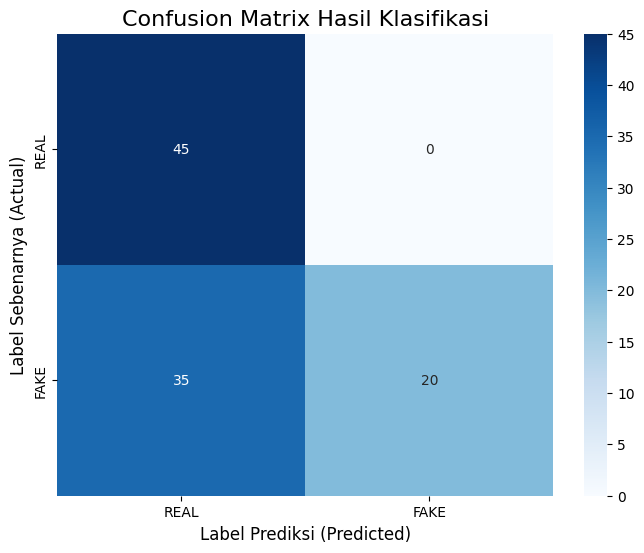

/tmp/ipython-input-3343730811.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=predicted_labels, order=['REAL', 'FAKE'], palette=['#2a9d8f', '#e76f51'])


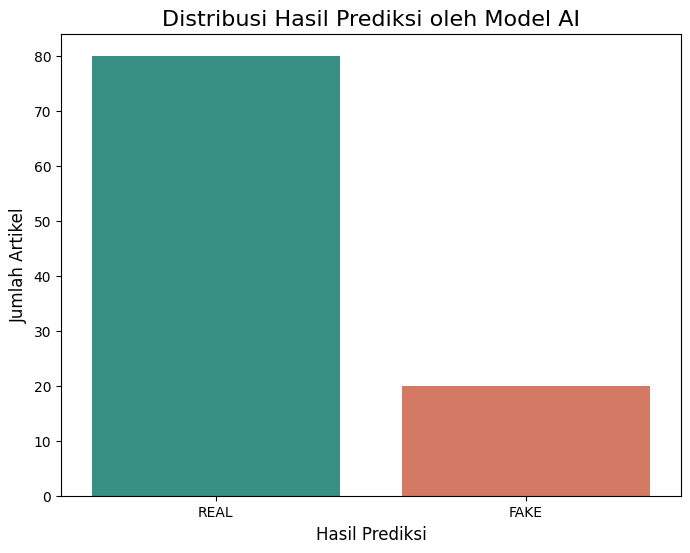



✍️ CONTOH HASIL PERINGKASAN

--- [Contoh Berita FAKE] ---
Judul:  BREAKING: GOP Chairman Grassley Has Had Enough, DEMANDS Trump Jr. Testimony. Donald Trump s White H...

Ringkasan AI:
Gagal membuat ringkasan.

--- [Contoh Berita REAL] ---
Judul: California AG pledges to defend birth control insurance coverage. SAN FRANCISCO (Reuters) - Californ...

Ringkasan AI:
Gagal membuat ringkasan.


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# --- A. Evaluasi Kuantitatif ---
# Memfilter hasil yang valid untuk perhitungan akurasi
valid_predictions = df_sample[df_sample['predicted_label'].isin(['REAL', 'FAKE'])]

if not valid_predictions.empty:
    actual_labels = valid_predictions['label']
    predicted_labels = valid_predictions['predicted_label']

    # Menghitung akurasi
    accuracy = accuracy_score(actual_labels, predicted_labels)
    print("📊 HASIL EVALUASI MODEL\n" + "="*25)
    print(f"Akurasi Model: {accuracy * 100:.2f}%\n")

    # Menampilkan laporan klasifikasi (precision, recall, f1-score)
    print("Laporan Klasifikasi Rinci:")
    print(classification_report(actual_labels, predicted_labels, target_names=['FAKE', 'REAL']))

    # --- B. Visualisasi Hasil Klasifikasi ---
    print("\n\n📈 VISUALISASI HASIL\n" + "="*22)

    # 1. Confusion Matrix
    # -------------------
    # Membuat confusion matrix untuk melihat detail performa
    cm = confusion_matrix(actual_labels, predicted_labels, labels=['REAL', 'FAKE'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])

    plt.title('Confusion Matrix Hasil Klasifikasi', fontsize=16)
    plt.ylabel('Label Sebenarnya (Actual)', fontsize=12)
    plt.xlabel('Label Prediksi (Predicted)', fontsize=12)
    plt.show()


    # 2. Bar Chart Jumlah Prediksi
    # -----------------------------
    # Membuat bar chart untuk melihat distribusi hasil prediksi model
    plt.figure(figsize=(8, 6))
    sns.countplot(x=predicted_labels, order=['REAL', 'FAKE'], palette=['#2a9d8f', '#e76f51'])

    plt.title('Distribusi Hasil Prediksi oleh Model AI', fontsize=16)
    plt.xlabel('Hasil Prediksi', fontsize=12)
    plt.ylabel('Jumlah Artikel', fontsize=12)
    plt.show()

else:
    print("❌ Tidak ada prediksi valid yang dihasilkan. Evaluasi tidak dapat dilakukan.")
    print("Coba periksa kembali koneksi API atau output dari model AI Anda.")

print("\n\n✍️ CONTOH HASIL PERINGKASAN\n" + "="*30)

# Mengambil satu contoh berita FAKE dan REAL untuk diringkas
sample_fake_article = df_sample[df_sample['label'] == 'FAKE'].iloc[0]
sample_real_article = df_sample[df_sample['label'] == 'REAL'].iloc[0]

print("\n--- [Contoh Berita FAKE] ---")
print(f"Judul: {sample_fake_article['full_text'][:100]}...")
summary_fake = summarize_article(sample_fake_article['full_text'])
print(f"\nRingkasan AI:\n{summary_fake}")

print("\n--- [Contoh Berita REAL] ---")
print(f"Judul: {sample_real_article['full_text'][:100]}...")
summary_real = summarize_article(sample_real_article['full_text'])
print(f"\nRingkasan AI:\n{summary_real}")
